# Neutrino event classification

This mini-project's dataset is comprised of a number of small files containing images of simulated neutrino interactions in a hypothetical detector that looks an awful lot like the detectors of the NOvA experiment. For each neutrino interaction the images consist of two $100 \times 80$ pixel images that represent the $x \times z$ and $y \times z$ projections of the tracks of particles in the detector.

The data for this mini-project comes in the form of the following files:

| File | Description |
| ----------- | ----------- |
| neutrino1.h5 | The 1st HDF5 file containing event images and meta deta |
| $\vdots$ | The middle ones |
| neutrino200.h5| The 200th HDF5 file|


The images show the energy deposited by simulated neutrinos in a NOvA like detector. Some of the meta information in the hdf5 file is described below

| Label | Description |
| ----------- | ----------- |
| neutrino/nuenergy | Neutrino Energy (GeV) |
| neutrino/lepenergy | Lepton Energy (GeV) |
| neutrino/finalstate | Interaction |
| neutrino/finalstate | Final State |
 

The [PDG code](https://pdg.lbl.gov/2019/reviews/rpp2019-rev-monte-carlo-numbering.pdf) is a number which identifies the particle type (e.g electron=11, electron-neutrino=12, etc.)

The $interaction$ says what kind of interaction occured and is defined in the enumeration below.

## Machine learning tasks
1. Develop a machine learning classifier that can successfully identify $\nu_\mu$ charged-current events
2. Test your machine learning classifier and investigate how the efficiency of the classifier depends on the meta data variables shown above

### Potential extensions
1. Write a machine learning algorithm to determine the energy of the neutrino
2. Write a machine learning algorithm to determine the flavour of the neutrino
3. Write a machine learning algorithm to determine $y=$ lepton energy over neutrino energy
4. Write a machine learning algorithm to determine the number of protons or pions
5. Write a machine learning algorithm to determine the interaction mode.




In [1]:
#imports

import h5py
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
import pandas as pd



import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.callbacks import ModelCheckpoint
from keras.utils.vis_utils import plot_model
import pydot
import graphviz

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import roc_curve

In [2]:
import enum 
class Interaction(enum.Enum):
    kNumuQE =0           # Numu CC QE interaction
    kNumuRes =1           # Numu CC Resonant interaction
    kNumuDIS = 2          # Numu CC DIS interaction
    kNumuOther = 3        # Numu CC, other than above
    kNueQE = 4            # Nue CC QE interaction
    kNueRes = 5           # Nue CC Resonant interaction
    kNueDIS = 6           # Nue CC DIS interaction
    kNueOther = 7         # Nue CC, other than above
    kNutauQE = 8          # Nutau CC QE interaction
    kNutauRes = 9         # Nutau CC Resonant interaction
    kNutauDIS =10         # Nutau CC DIS interaction
    kNutauOther =11       # Nutau CC, other than above
    kNuElectronElastic = 12# NC Nu On E Scattering
    kNC =13                # NC interaction
    kCosmic =14           # Cosmic ray background
    kOther =15            # Something else.  Tau?  Hopefully we don't use this
    kNIntType=16          # Number of interaction types, used like a vector size

    
class FinalState(enum.Enum):
    kNumu0tr0sh=0          # Numu CC - no track no shower
    kNumu0tr1sh=1          # Numu CC - no track  1 shower
    kNumu0tr2sh=enum.auto()          # Numu CC - no track  2 shower
    kNumu0trMsh=enum.auto()          # Numu CC - no track 3+ shower
    kNumu1tr0sh=enum.auto()          # Numu CC -  1 track no shower
    kNumu1tr1sh=enum.auto()          # Numu CC -  1 track  1 shower
    kNumu1tr2sh=enum.auto()          # Numu CC -  1 track  2 shower
    kNumu1trMsh=enum.auto()          # Numu CC -  1 track 3+ shower
    kNumu2tr0sh=enum.auto()          # Numu CC -  2 track no shower
    kNumu2tr1sh=enum.auto()          # Numu CC -  2 track  1 shower
    kNumu2tr2sh=enum.auto()          # Numu CC -  2 track  2 shower
    kNumu2trMsh=enum.auto()          # Numu CC -  2 track 3+ shower
    kNumuMtr0sh=enum.auto()          # Numu CC - 3+ track no showe
    kNumuMtr1sh=enum.auto()          # Numu CC - 3+ track  1 shower
    kNumuMtr2sh=enum.auto()          # Numu CC - 3+ track  2 showe
    kNumuMtrMsh=enum.auto()          # Numu CC - 3+ track 3+ shower
    kNue0tr0sh=enum.auto()           # Nue CC - no track no shower
    kNue0tr1sh=enum.auto()           # Nue CC - no track  1 shower
    kNue0tr2sh=enum.auto()           # Nue CC - no track  2 showe
    kNue0trMsh=enum.auto()           # Nue CC - no track 3+ shower
    kNue1tr0sh=enum.auto()           # Nue CC -  1 track no shower
    kNue1tr1sh=enum.auto()           # Nue CC -  1 track  1 shower
    kNue1tr2sh=enum.auto()           # Nue CC -  1 track  2 shower
    kNue1trMsh=enum.auto()           # Nue CC -  1 track 3+ shower
    kNue2tr0sh=enum.auto()           # Nue CC -  2 track no shower
    kNue2tr1sh=enum.auto()           # Nue CC -  2 track  1 shower
    kNue2tr2sh=enum.auto()           # Nue CC -  2 track  2 shower
    kNue2trMsh=enum.auto()           # Nue CC -  2 track 3+ shower
    kNueMtr0sh=enum.auto()           # Nue CC - 3+ track no shower
    kNueMtr1sh=enum.auto()           # Nue CC - 3+ track  1 shower
    kNueMtr2sh=enum.auto()           # Nue CC - 3+ track  2 shower
    kNueMtrMsh=enum.auto()           # Nue CC - 3+ track 3+ shower
    kNC0tr0sh=enum.auto()           # NC CC - no track no shower
    kNC0tr1sh=enum.auto()           # NC CC - no track  1 shower
    kNC0tr2sh=enum.auto()           # NC CC - no track  2 shower
    kNC0trMsh=enum.auto()           # NC CC - no track 3+ shower
    kNC1tr0sh=enum.auto()           # NC CC -  1 track no shower
    kNC1tr1sh=enum.auto()           # NC CC -  1 track  1 shower
    kNC1tr2sh=enum.auto()           # NC CC -  1 track  2 shower
    kNC1trMsh=enum.auto()           # NC CC -  1 track 3+ shower
    kNC2tr0sh=enum.auto()           # NC CC -  2 track no shower
    kNC2tr1sh=enum.auto()           # NC CC -  2 track  1 shower
    kNC2tr2sh=enum.auto()           # NC CC -  2 track  2 shower
    kNC2trMsh=enum.auto()           # NC CC -  2 track 3+ shower
    kNCMtr0sh=enum.auto()           # NC CC - 3+ track no shower
    kNCMtr1sh=enum.auto()           # NC CC - 3+ track  1 shower
    kNCMtr2sh=enum.auto()           # NC CC - 3+ track  2 shower
    kNCMtrMsh=enum.auto()           # NC CC - 3+ track 3+ shower
    kCosmicFS=enum.auto()           # Cosmic ray background
    kOtherFS=enum.auto()            # Something else.  Tau?  Hopefully we don't use this
    kNFStType=enum.auto()            # Number of interaction types, used like a vector size



In [3]:
# import the urllib library
import urllib.request
 
# Copy a network object to a local file
urllib.request.urlretrieve('http://www.hep.ucl.ac.uk/undergrad/0056/other/projects/nova/neutrino1.h5', "neutrino1.h5")

#Open the local h5 file with h5py
df=h5py.File('neutrino1.h5','r')
type(df)

h5py._hl.files.File

In [4]:
#Print the keys in the neutrino meta data
print(df.keys())
print(df['neutrino'].keys())

#Get an numpy array containing the event image, and reshape it from flat to 2x100x80
print(np.shape(df['cvnmap']))
print(df['neutrino']['evt'])
event0=np.array(df['cvnmap'][3]).reshape((2,100,80))

<KeysViewHDF5 ['cvnmap', 'neutrino']>
<KeysViewHDF5 ['cycle', 'evt', 'finalstate', 'finalstateprong', 'interaction', 'lepenergy', 'nuenergy', 'parent', 'particles', 'rec.training.trainingdata_idx', 'run', 'subevt', 'subrun', 'vtxx', 'vtxy', 'vtxz']>
(7001, 16000)
<HDF5 dataset "evt": shape (7001, 1), type "<u4">


Text(0, 0.5, 'z')

<Figure size 720x576 with 0 Axes>

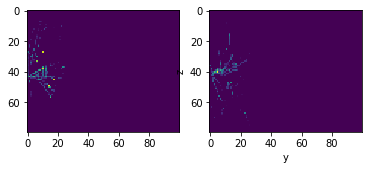

In [5]:
#Plot the first event, look it is a nice long muon track
plt.figure(figsize = (10,8))
fig, ax = plt.subplots(1,2)
ax[0].imshow(event0[1].T)
plt.xlabel('x')
plt.ylabel('z')
ax[1].imshow(event0[0].T)
plt.xlabel('y')
plt.ylabel('z')

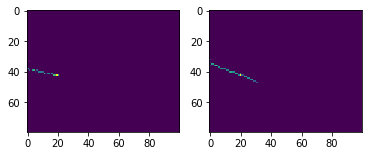

In [6]:
event1=np.array(df['cvnmap'][4]).reshape((2,100,80))
fig, ax = plt.subplots(1,2)
ax[0].imshow(event1[1].T)
ax[1].imshow(event1[0].T)

In [7]:
print("Neutrino Final State code",df['neutrino']['finalstate'][3])
print("Interaction was ",Interaction(df['neutrino']['interaction'][3]))
print("Neutrino energy",df['neutrino']['nuenergy'][3],"GeV")

Neutrino Final State code [46]
Interaction was  Interaction.kNC
Neutrino energy [13.677229] GeV


(array([3358., 1891., 1013.,  394.,  184.,   85.,   44.,   14.,    8.,
          10.]),
 array([ 0.      ,  8.229538, 16.459076, 24.688614, 32.91815 , 41.14769 ,
        49.377228, 57.606766, 65.8363  , 74.06584 , 82.29538 ],
       dtype=float32),
 <a list of 10 Patch objects>)

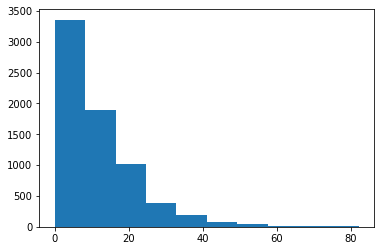

In [8]:
fs=np.array(df['neutrino']['finalstate'])
nuenergy=np.array(df['neutrino']['nuenergy'])
fig, ax = plt.subplots()
ax.hist(nuenergy)

## Preprocessing
In this section, we gather the relevant images as well as the label data which we process it into a Pandas DataFrame object. 

**Tasks** 
* Write a function which creates a Pandas DataFrame from the label data
* Write a function that collects the input images (this will be the input for the machine learning tasks). 
* Gather different files from the UCL website, apply the function defined above and concatenate to the master DataFrame.
* Normalise the image scale. 
* Define a function which builds a neural network. 

### 1. Write a function that creates a Pandas DataFrame from the label data

In [9]:
def toDF(df): 
   
    #Get the labels or column names for our dataframe. This will always be the keys in the neutrino file. 
    labels = list(df['neutrino'].keys())
    
    
    #create a dictionary with the label names for keys and the array of the data for each column as values. 
    d = {str(label) : np.array(df['neutrino'][str(label)]).T[0] for label in labels}
    
    #convert the dictionary to a pandas dataframe. 
    df = pd.DataFrame.from_dict(d)
    
    return df

### 2. Write a function that collects the input images

In [10]:
def getX(df): 
    
    #create a numpy array from the images
    input_array = np.array(df['cvnmap'])
    
    #Now we create our input array by changing the shape of the images from flat to 2*100*80
    X = input_array.reshape(input_array.shape[0], 2,100,80)
    X1 = X[:,0].reshape(input_array.shape[0],100, 80,1)
    X2 = X[:,1].reshape(input_array.shape[0],100, 80,1)
    X = np.concatenate([X1,X2], axis=3)

    return X 
    
    
    

### 3. Gather different files from the UCL website and append them to a master DataFrame

In [11]:

#empty label df 
label_df = pd.DataFrame()

#empty input array
X = np.zeros((0, 100,80,2))

for filenum in range(1,16):
    
    #gather the different files from the UCL website
    urllib.request.urlretrieve('http://www.hep.ucl.ac.uk/undergrad/0056/other/projects/nova/neutrino'+str(filenum)+'.h5', 'neutrino'+str(filenum)+'.h5')
    df = h5py.File('neutrino'+ str(filenum)+'.h5','r')
    
    #get the input features
    inputs = getX(df)
    X = np.concatenate([X, inputs], axis = 0)
    
    #convert the feature file into a pandas df
    df = toDF(df)
    
    #append it to the label dataframe
    label_df= label_df.append(df)
    
    print('Done: {}/15'.format(filenum))

Done: 1/15
Done: 2/15
Done: 3/15
Done: 4/15
Done: 5/15
Done: 6/15
Done: 7/15
Done: 8/15
Done: 9/15
Done: 10/15
Done: 11/15
Done: 12/15
Done: 13/15
Done: 14/15
Done: 15/15


In [12]:
label_df.head()

,cycle,evt,finalstate,finalstateprong,interaction,lepenergy,nuenergy,parent,particles,rec.training.trainingdata_idx,run,subevt,subrun,vtxx,vtxy,vtxz
0,15,1,8,1,0,32.837307,33.076805,1,23,0,12053,1,0,-76.117852,311.595491,-1757.971398
1,15,1,12,3,2,0.986411,6.852915,1,33,0,12053,2,0,376.344346,232.187717,389.125703
2,15,1,13,3,2,0.631563,1.641000,0,23,0,12053,3,0,47.172435,-161.841829,871.827338
3,15,1,46,11,13,2.768984,13.677229,4,70,0,12053,5,0,28.927787,128.163077,726.942543
4,15,1,49,13,0,1.848964,1.892379,0,270,0,12053,7,0,-158.862074,175.131230,94.934196


In [13]:
label_df.shape, X.shape

((103970, 16), (103970, 100, 80, 2))

In [14]:
np.min(X)

0.0

In [15]:
np.max(X)

255.0

In [16]:
label_df.dtypes

cycle                              int32
evt                               uint32
finalstate                        uint32
finalstateprong                   uint32
interaction                       uint32
lepenergy                        float32
nuenergy                         float32
parent                            uint32
particles                         uint32
rec.training.trainingdata_idx     uint32
run                               uint32
subevt                            uint16
subrun                            uint32
vtxx                             float64
vtxy                             float64
vtxz                             float64
dtype: object

In [17]:
X.shape

(103970, 100, 80, 2)

### 4. Normalise the images

In [18]:
maxX = np.max(X)
#maxX.shape

In [19]:
maxX

255.0

In [20]:

X = X/maxX

In [21]:
np.max(X)

1.0

### 5. Write a function that builds a Neural Network 

Throughout this notebook, several neural networks will be used. Even though most of them won't be featured in the final version of the project, it could be useful to write a function which creates a sequential model. 

## Machine Learning Tasks 
### 1. Develop a machine learning classifier that can successfully identify $\nu_\mu$ charged-current events

#### Sub tasks


* Get the labels. 
* Split the data.
* Under-sample
* Split the images in the $x-z$ and $y-z$ components
* Build a model/ decide the architecture.
* Train the model. 
* Evaluate the model

#### Get the labels

For this task, we're only interested in identifying $\mu_\nu $ charged-current events in general and there are 3 different types of $\mu_\nu $ charged-current events. These correspond to values ```0,1,2,3``` in the ```interaction``` column. Since this is a binary classification task, we need to create a label array containing only 1s and 0s. In mathematical notation, we can write the function which maps the elements from ```interaction ```to the label array: $$\forall x \in S, y: S \to \{0,1\}: \begin{cases} y(x) = 1, \mbox{ if } x \leq 3 \\ y(x) = 0, \mbox{ if } x > 3 \end{cases} $$

In [22]:
labels_idx = np.where(label_df.interaction <= 3)
print(labels_idx[0][:10])
y = np.zeros(len(label_df.interaction))
y[labels_idx[0]] = 1
y = y.astype(int)

[ 0  1  2  4  8  9 10 11 12 13]


In [23]:
y[:5].T, label_df.interaction[:5]

(array([1, 1, 1, 0, 1]),
 0     0
 1     2
 2     2
 3    13
 4     0
 Name: interaction, dtype: uint32)

In [24]:
len(np.where(y==0)[0]), len(np.where(y==1)[0])

(12435, 91535)

In [25]:
y = y.reshape(y.shape[0],1)
y.shape

(103970, 1)

In [26]:
np.min(y), np.max(y)

(0, 1)

Now, let's analyse the label data to look at the class distribution:

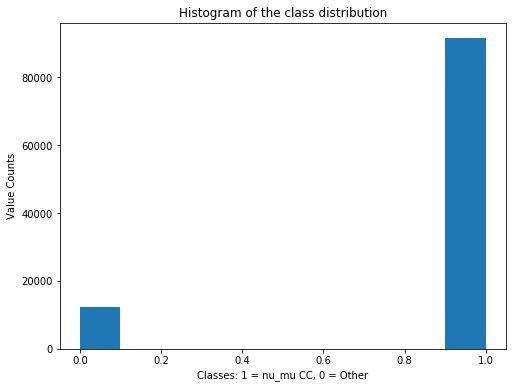

In [27]:
plt.figure(figsize = (8,6))
plt.hist(y)
plt.title('Histogram of the class distribution');
plt.xlabel('Classes: 1 = nu_mu CC, 0 = Other');
plt.ylabel('Value Counts');

We can notice that our classes imbalanced, with about 88% of all our observations representing $\nu_{\mu}$ charged-current events. This could lead to our model ignoring one class and classifying all images into one category to maximise the accuracy.

#### Split the data

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.1, shuffle = True)

In [29]:
X_train.shape, y_train.shape

((93573, 100, 80, 2), (93573, 1))

#### Under-Sample

In [30]:
def UnderSamplingIdx(data):
    majority_indices = np.where(data ==1)[0]
    minority_indices = np.where(data == 0)[0]
    
    random_majority_indices = np.random.choice(majority_indices,len(minority_indices), replace = False )
    
    under_sampling_indices = np.concatenate([random_majority_indices, minority_indices])
    
    return under_sampling_indices
    

In [31]:
under_sampling_indices = UnderSamplingIdx(y_train)
y_train = y_train[under_sampling_indices]
X_train = X_train[under_sampling_indices]

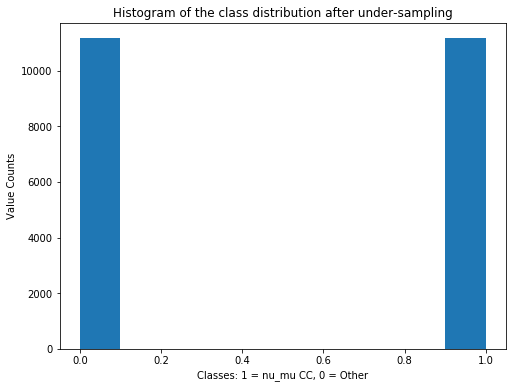

In [32]:
plt.figure(figsize = (8,6))
plt.hist(y_train)
plt.title('Histogram of the class distribution after under-sampling');
plt.xlabel('Classes: 1 = nu_mu CC, 0 = Other');
plt.ylabel('Value Counts');

#### Split the images into $x-z$ and $y-z$ components

In [33]:
def ImageSplit(images, n_images):
    
    ''' This function splits a doublet of images into one projection on the xz axis and one projection
    on the yz axis'''
    images = images.reshape(n_images, 2,100,80)
    XZ  = images[:,0].reshape(n_images, 100,80,1)
    YZ  = images[:,1].reshape(n_images, 100,80,1)
    
    return XZ,YZ

In [34]:
n_training_images = y_train.shape[0]
XZ_train = ImageSplit(X_train, n_training_images )[0]
YZ_train = ImageSplit(X_train, n_training_images)[1]
XZ_train.shape,YZ_train.shape

((22334, 100, 80, 1), (22334, 100, 80, 1))

In [35]:
n_testing_images = y_test.shape[0]
n_training_images = y_train.shape[0]
XZ_test = ImageSplit(X_test, n_testing_images)[0]
YZ_test = ImageSplit(X_test, n_testing_images)[1]
XZ_test.shape,YZ_test.shape

((10397, 100, 80, 1), (10397, 100, 80, 1))

#### Build a model

In [36]:
XZ_input = keras.Input( shape = (100,80,1), name = 'xz_img')
YZ_input = keras.Input( shape = (100,80,1), name = 'yz_img')

xz = layers.Conv2D(8, (5,5), activation = 'relu', padding ='same')(XZ_input)
xz = layers.MaxPooling2D((2,2))(xz)
xz = layers.Flatten()(xz)

yz = layers.Conv2D(8, (5,5), activation = 'relu', padding = 'same')(YZ_input)
yz = layers.MaxPooling2D((2,2))(yz)
yz = layers.Flatten()(yz)

x = layers.concatenate([xz,yz])
x = layers.Dense(128, activation = 'relu')(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(64, activation = 'relu')(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(32, activation = 'relu')(x)
x = layers.Dense(16, activation = 'relu')(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(8, activation = 'relu')(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(4, activation = 'relu')(x)
x = layers.Dropout(0.1)(x)
pred = layers.Dense(1, activation = 'sigmoid')(x)

model = keras.Model(
    inputs=[XZ_input, YZ_input],
    outputs=[pred])
model.summary()
plot_model(model, "multi_input_and_output_model.png", show_shapes=True)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
xz_img (InputLayer)             [(None, 100, 80, 1)] 0                                            
__________________________________________________________________________________________________
yz_img (InputLayer)             [(None, 100, 80, 1)] 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 100, 80, 8)   208         xz_img[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 100, 80, 8)   208         yz_img[0][0]                     
______________________________________________________________________________________________

In [37]:
model.compile(optimizer= tf.keras.optimizers.Adam(learning_rate=0.001),
          loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
          metrics=tf.keras.metrics.BinaryAccuracy(
    name="binary_accuracy", dtype=None, threshold=0.5))

In [38]:
history = model.fit({'xz_img': XZ_train, 'yz_img': YZ_train},y_train, epochs = 15, batch_size = 500, validation_data = ([XZ_test, YZ_test], y_test), verbose = 1)

Epoch 1/15
45/45 [==============================] - 118s 3s/step - loss: 0.6580 - binary_accuracy: 0.6045 - val_loss: 0.5731 - val_binary_accuracy: 0.5481
Epoch 2/15
45/45 [==============================] - 109s 2s/step - loss: 0.5976 - binary_accuracy: 0.6902 - val_loss: 0.5856 - val_binary_accuracy: 0.5504
Epoch 3/15
45/45 [==============================] - 109s 2s/step - loss: 0.5605 - binary_accuracy: 0.7207 - val_loss: 0.5171 - val_binary_accuracy: 0.5971
Epoch 4/15
45/45 [==============================] - 98s 2s/step - loss: 0.5241 - binary_accuracy: 0.7491 - val_loss: 0.4789 - val_binary_accuracy: 0.6359
Epoch 5/15
45/45 [==============================] - 99s 2s/step - loss: 0.4903 - binary_accuracy: 0.7737 - val_loss: 0.4518 - val_binary_accuracy: 0.6714
Epoch 6/15
45/45 [==============================] - 98s 2s/step - loss: 0.4608 - binary_accuracy: 0.7960 - val_loss: 0.4502 - val_binary_accuracy: 0.6984
Epoch 7/15
45/45 [==============================] - 102s 2s/step - loss: 

In [39]:
pred = model.predict([XZ_test, YZ_test]).round()

In [40]:
np.unique(pred, return_counts = True)

(array([0., 1.], dtype=float32), array([3767, 6630]))

In [41]:
cnf_matrix = confusion_matrix(y_test, pred)

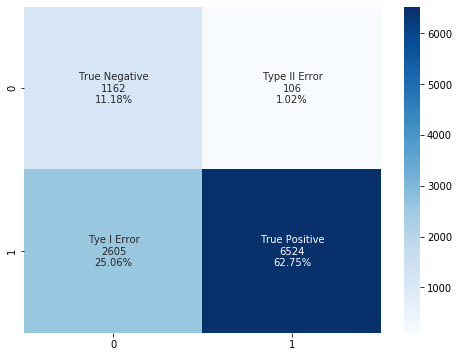

In [42]:
plt.figure(figsize= (8,6))
group_names = ['True Negative','Type II Error','Tye I Error','True Positive']
group_counts = ['{0:0.0f}'.format(value) for value in
                cnf_matrix.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in
                     cnf_matrix.flatten()/np.sum(cnf_matrix)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cnf_matrix, annot=labels, fmt='', cmap='Blues');

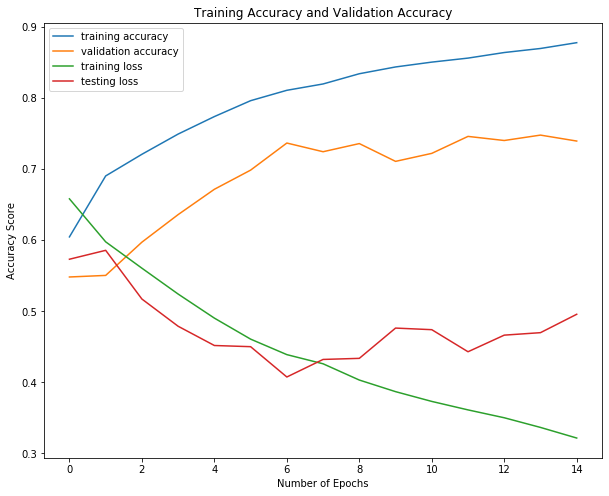

In [43]:
training_accuracy = history.history['binary_accuracy']
training_loss = history.history['loss']
testing_accuracy = history.history['val_binary_accuracy']
testing_loss = history.history['val_loss']
plt.figure(figsize = (10,8))

plt.plot(training_accuracy, label = 'training accuracy')
plt.plot(testing_accuracy, label = 'validation accuracy')
plt.plot(training_loss, label= 'training loss')
plt.plot(testing_loss, label = 'testing loss')
plt.title('Training Accuracy and Validation Accuracy')
plt.ylabel('Accuracy Score')
plt.xlabel('Number of Epochs')
plt.legend();

In [44]:
matthews_corrcoef(y_test, pred.round())

0.42961558539486716

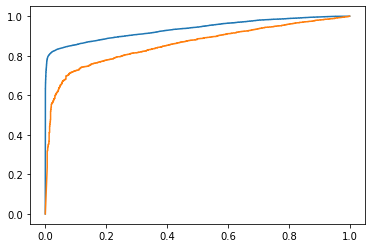

In [45]:
plt.plot(roc_curve(y_train, model.predict([XZ_train, YZ_train]))[0], roc_curve(y_train, model.predict([XZ_train, YZ_train]))[1] )
plt.plot(roc_curve(y_test, model.predict([XZ_test, YZ_test]))[0], roc_curve(y_test, model.predict([XZ_test, YZ_test]))[1] )